# RNN vs Longstaff-Schwartz: Heston Model American Basket Option Comparison

This notebook compares the performance of Neural Network (RNN-based) and traditional Longstaff-Schwartz Monte Carlo methods for pricing American arithmetic basket options under the Heston stochastic volatility model. We use calibrated Heston parameters for 30 real stocks and compare both delta and alpha-derived hedging strategies from the RNN model.

## Setup and Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from typing import Literal

# Import both implementations
import sys
sys.path.append('..')
from longstaff_schwartz import LSMOptionPricer, CorrelatedHeston
from heston_rnn_model import RNNAmericanHestonAlphaTrainer

# Model parameters (using calibrated Heston data)
n_assets = 30  # Use all stocks in the CSV
r = 0.04
T = 3/12  # 3 months maturity
step = int(252/2)  # 126 time steps
N_train = 300000   # Training paths for LSM (restored to match streamlined)
N_test = 300000    # Test paths for LSM (restored to match streamlined)
weights = np.full(n_assets, 1.0 / n_assets)  # Equal weight portfolio

# Load actual stock prices from CSV data
heston_params_df = pd.read_csv('../heston_parameters.csv')
print(f"Loaded Heston parameters for {len(heston_params_df)} assets")

# Extract S0 (current stock prices) from the CSV
S0 = heston_params_df['Spot_Price'].values
print(f"Loaded stock prices: S0 shape = {S0.shape}")

# Calculate arithmetic basket price and set strike
current_basket_price = np.sum(S0 * weights)  # Arithmetic weighted basket
K = current_basket_price * 1.05  # 5% ITM put option to ensure early exercise value

print(f"\nMarket Parameters:")
print(f"Assets: {n_assets}, Current arithmetic basket: ${current_basket_price:.2f}, Strike: ${K:.2f}")
print(f"Individual S0 range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"Basket type: Arithmetic (weighted sum of prices)")
print(f"Put option: 5% ITM (K/S0 = {K/current_basket_price:.3f})")
print(f"T: {T:.3f}y ({T*12:.1f} months), r: {r*100:.1f}%")
print(f"Training paths: {N_train:,}, Test paths: {N_test:,}")
print(f"Time steps: {step}")

Loaded Heston parameters for 30 assets
Loaded stock prices: S0 shape = (30,)

Market Parameters:
Assets: 30, Current arithmetic basket: $275.26, Strike: $289.02
Individual S0 range: $25.35 - $1261.95
Basket type: Arithmetic (weighted sum of prices)
Put option: 5% ITM (K/S0 = 1.050)
T: 0.250y (3.0 months), r: 4.0%
Training paths: 300,000, Test paths: 300,000
Time steps: 126


## Heston Model Specification with Calibrated Parameters

In [2]:
# Load correlation matrix and extract calibrated Heston parameters
corr_matrix_df = pd.read_csv('../heston_correlation_matrix.csv', index_col=0)

# Use all assets from calibrated data
selected_tickers = heston_params_df['Ticker'].tolist()
selected_params = heston_params_df

# Extract Heston parameters for all assets
v0 = selected_params['v0'].values        # Initial variance
theta = selected_params['theta'].values   # Long-term variance
kappa = selected_params['kappa'].values   # Mean reversion speed
sigma_v = selected_params['sigma'].values # Vol of vol
rho_sv = selected_params['rho'].values    # Stock-vol correlation

# Get correlation matrix for all assets
correlation_matrix = corr_matrix_df.loc[selected_tickers, selected_tickers].values

print(f"\nHeston Model Parameters (Calibrated):")
print(f"Selected assets: {len(selected_tickers)} stocks")
print(f"Tickers: {selected_tickers[:5]}...{selected_tickers[-3:]}")
print(f"\nCalibrated Parameter Ranges:")
print(f"  Initial volatility: {np.sqrt(v0.min())*100:.1f}% - {np.sqrt(v0.max())*100:.1f}%")
print(f"  Long-term volatility: {np.sqrt(theta.min())*100:.1f}% - {np.sqrt(theta.max())*100:.1f}%")
print(f"  Mean reversion speed: {kappa.min():.2f} - {kappa.max():.2f}")
print(f"  Vol of vol: {sigma_v.min()*100:.1f}% - {sigma_v.max()*100:.1f}%")
print(f"  Stock-vol correlation: {rho_sv.min():.3f} - {rho_sv.max():.3f}")
print(f"  Average stock correlation: {np.mean(correlation_matrix[np.triu_indices(n_assets, k=1)]):.3f}")

# Verify correlation matrix is positive definite
eigvals = np.linalg.eigvals(correlation_matrix)
if np.all(eigvals > 0):
    print("✓ Correlation matrix is positive definite")
else:
    print(f"⚠ Warning: Correlation matrix has {np.sum(eigvals <= 0)} non-positive eigenvalues")
    
print(f"\nOption Details:")
print(f"Current basket price: {current_basket_price:.4f}")
print(f"Strike price: {K:.4f}")
print(f"Moneyness (K/S0): {K/current_basket_price:.4f}")


Heston Model Parameters (Calibrated):
Selected assets: 30 stocks
Tickers: ['AMZN', 'GOOGL', 'TSLA', 'NVDA', 'AAPL']...['XOM', 'CVX', 'V']

Calibrated Parameter Ranges:
  Initial volatility: 10.0% - 65.2%
  Long-term volatility: 11.6% - 55.9%
  Mean reversion speed: 2.10 - 15.00
  Vol of vol: 33.7% - 398.2%
  Stock-vol correlation: -0.893 - -0.053
  Average stock correlation: 0.488
✓ Correlation matrix is positive definite

Option Details:
Current basket price: 275.2597
Strike price: 289.0226
Moneyness (K/S0): 1.0500


## Method 1: Longstaff-Schwartz Monte Carlo (LSM) with Heston

In [ ]:
print("=" * 60)
print("LONGSTAFF-SCHWARTZ MONTE CARLO PRICING (HESTON MODEL)")
print("=" * 60)

# Initialize LSM pricer with Heston model
lsm_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="heston",
    basket_kind="arithmetic",
    include_variance_state=True,  # Include variance in regression for Heston
    degree=1,  # Keep degree=1 for speed but include variance state
    
    # Heston parameters
    v0=v0,
    theta=theta,
    kappa=kappa,
    sigma=sigma_v,
    rho_sv=rho_sv,
    corr_matrix=correlation_matrix
)

# Train LSM with timing
print(f"Training LSM with {N_train:,} paths using Heston model...")
start_time = time.time()
train_seed = 12345
lsm_price, lsm_std, lsm_se = lsm_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
lsm_train_time = time.time() - start_time

# European option price for comparison (same paths)
euro_payoff = lsm_pricer.payoff[:, -1]  # Payoff at maturity
euro_price = float(np.mean(euro_payoff)) * np.exp(-r * T)  # Discount payoff to t=0
early_exercise_premium = lsm_price - euro_price

print(f"\nLSM Results (Heston Model):")
print(f"American PUT: {lsm_price:.6f} ± {lsm_se:.6f} (SE), STD={lsm_std:.6f}")
print(f"European PUT: {euro_price:.6f}")
print(f"Early Exercise Premium: {early_exercise_premium:.6f} ({early_exercise_premium/euro_price*100:+.2f}%)")
print(f"Training Time: {lsm_train_time:.2f} seconds")

# Out-of-sample testing (restored batches for speed)
print(f"\nOut-of-sample testing with 5 batches...")
test_seeds = [101, 202, 303, 404, 505]
lsm_test_prices = []
lsm_test_time = 0

for i, seed in enumerate(test_seeds, 1):
    start_time = time.time()
    tp, tstd, tse = lsm_pricer.test(n_test_paths=N_test, seed=seed)
    test_time = time.time() - start_time
    lsm_test_time += test_time
    lsm_test_prices.append(tp)
    diff = tp - lsm_price
    flag = abs(diff) > 2.0 * np.sqrt(lsm_se**2 + tse**2)
    mark = " **" if flag else ""
    print(f"  Batch {i}: {tp:.6f} ± {tse:.6f} (SE), Δ={diff:+.6f}{mark} [{test_time:.1f}s]")

lsm_mean_test = float(np.mean(lsm_test_prices))
lsm_bias = lsm_mean_test - lsm_price
lsm_test_std = float(np.std(lsm_test_prices, ddof=1))

print(f"\nLSM Summary:")
print(f"Mean OOS Price: {lsm_mean_test:.6f}")
print(f"Bias (OOS - Train): {lsm_bias:+.6f}")
print(f"OOS Standard Deviation: {lsm_test_std:.6f}")
print(f"Total Test Time: {lsm_test_time:.2f} seconds")
print(f"Average Test Time per Batch: {lsm_test_time/len(test_seeds):.2f} seconds")

LONGSTAFF-SCHWARTZ MONTE CARLO PRICING (HESTON MODEL)
Training LSM with 300,000 paths using Heston model...

LSM Results (Heston Model):
American PUT: 18.260377 ± 0.029605 (SE), STD=16.215227
European PUT: 17.867857
Early Exercise Premium: 0.392520 (+2.20%)
Training Time: 219.84 seconds

Out-of-sample testing with 5 batches...

LSM Results (Heston Model):
American PUT: 18.260377 ± 0.029605 (SE), STD=16.215227
European PUT: 17.867857
Early Exercise Premium: 0.392520 (+2.20%)
Training Time: 219.84 seconds

Out-of-sample testing with 5 batches...
  Batch 1: 18.233383 ± 0.029564 (SE), Δ=-0.026994 [214.0s]
  Batch 1: 18.233383 ± 0.029564 (SE), Δ=-0.026994 [214.0s]
  Batch 2: 18.223794 ± 0.029565 (SE), Δ=-0.036583 [206.5s]
  Batch 2: 18.223794 ± 0.029565 (SE), Δ=-0.036583 [206.5s]
  Batch 3: 18.198196 ± 0.029591 (SE), Δ=-0.062181 [248.9s]
  Batch 3: 18.198196 ± 0.029591 (SE), Δ=-0.062181 [248.9s]
  Batch 4: 18.167882 ± 0.029577 (SE), Δ=-0.092495 ** [262.4s]
  Batch 4: 18.167882 ± 0.029577 (S

## Method 2: RNN-Based Neural Network Pricing (Heston with Alpha)

In [ ]:
print("\n" + "=" * 60)
print("RNN-BASED NEURAL NETWORK PRICING (HESTON WITH ALPHA)")
print("=" * 60)

print(f"RNN Model Setup:")
print(f"Using full 30-stock basket with calibrated Heston parameters:")
print(f"  Individual S0 range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"  Current basket price: ${current_basket_price:.2f}")
print(f"  Initial vol range: {np.sqrt(v0.min())*100:.1f}% - {np.sqrt(v0.max())*100:.1f}%")
print(f"  Strike: ${K:.2f} (5% ITM put)")

# Initialize RNN trainer with calibrated Heston parameters
rnn_trainer = RNNAmericanHestonAlphaTrainer(
    d=n_assets, 
    S0=S0,  # Use the vector of 30 individual stock prices
    K=K,  # Use the ITM strike
    r=r, 
    T=T, 
    N=step,  # 126 time steps
    
    # Heston parameters (calibrated)
    v0=v0,
    theta=theta,
    kappa_v=kappa,
    vol_of_vol=sigma_v,
    rho_sv=rho_sv,
    corr=correlation_matrix,  # Use full correlation matrix
    weights=weights,  # Pass the equal weights
    kind="put",
    
    # Training parameters (optimized for speed)
    M=100000,  # Number of training paths (reduced for speed)
    batch_size=4096, 
    epochs=30,  # Reduced for demo
    seed=12345,
    
    # Model architecture (smaller for speed)
    hidden_dim=64,  # Smaller for faster training
    num_layers=3,
    lr=1e-3,
    grad_clip=1.0,
    
    # RNN-specific parameters
    alpha_price=1.0,
    beta=0.5,  # Delta blend parameter
    z_weight=1.0,
    smooth_labels=True,
    smooth_only_at_maturity=False,
    lookahead_window=None,
    shuffle=False,
    drop_last=True,
    resimulate_every=1
)

# Train RNN with timing
print(f"\nTraining RNN with {rnn_trainer.M:,} paths, {rnn_trainer.epochs} epochs...")
print(f"Using vector S0 with {len(S0)} individual stock prices")
print(f"Using full {n_assets}x{n_assets} correlation matrix")
print(f"Basket weights: Equal weights ({1/n_assets:.3f} each)")
print(f"Heston parameters: Calibrated for each stock individually")
start_time = time.time()
rnn_trainer.train()
rnn_train_time = time.time() - start_time

print(f"\nRNN Training completed in {rnn_train_time:.2f} seconds")
print(f"Average time per epoch: {rnn_train_time/rnn_trainer.epochs:.2f} seconds")


RNN-BASED NEURAL NETWORK PRICING (HESTON WITH ALPHA)
RNN Model Setup:
Using full 30-stock basket with calibrated Heston parameters:
  Individual S0 range: $25.35 - $1261.95
  Current basket price: $275.26
  Initial vol range: 10.0% - 65.2%
  Strike: $289.02 (5% ITM put)


c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training RNN with 20,000 paths, 10 epochs...
Using vector S0 with 30 individual stock prices
Using full 30x30 correlation matrix
Basket weights: Equal weights (0.033 each)
Heston parameters: Calibrated for each stock individually
Epoch 01 | Loss 610.156382 | Value 610.153513 | Z(stock) 1.406386 (scaled 0.007) | Batches 9
Epoch 01 | Loss 610.156382 | Value 610.153513 | Z(stock) 1.406386 (scaled 0.007) | Batches 9
Epoch 02 | Loss 192.217985 | Value 192.216122 | Z(stock) 0.920035 (scaled 0.028) | Batches 9
Epoch 02 | Loss 192.217985 | Value 192.216122 | Z(stock) 0.920035 (scaled 0.028) | Batches 9
Epoch 03 | Loss 34.441539 | Value 34.440118 | Z(stock) 0.713290 (scaled 0.069) | Batches 9
Epoch 03 | Loss 34.441539 | Value 34.440118 | Z(stock) 0.713290 (scaled 0.069) | Batches 9
Epoch 04 | Loss 15.376858 | Value 15.375805 | Z(stock) 0.529934 (scaled 0.084) | Batches 9
Epoch 04 | Loss 15.376858 | Value 15.375805 | Z(stock) 0.529934 (scaled 0.084) | Batches 9
Epoch 05 | Loss 6.206337 | Value 

## RNN Inference and Out-of-Sample Testing

In [5]:
# RNN inference on cached training paths
print("RNN Inference:")
start_time = time.time()
rnn_y0_cached, rnn_V0_cached, rnn_deltas_cached, rnn_alphas_cached, rnn_hedge_cached, rnn_hedge_note = rnn_trainer.price_at_t0(
    inference_batch_size=10000,  # Restored to match streamlined version
    use_cached_paths=True
)
rnn_inference_time = time.time() - start_time

print(f"RNN Results (cached paths):")
print(f"Continuation Value: {rnn_y0_cached:.6f}")
print(f"American PUT: {rnn_V0_cached:.6f}")
print(f"Inference Time: {rnn_inference_time:.2f} seconds")
print(f"Hedge Strategy: {rnn_hedge_note}")

# Out-of-sample testing with multiple seeds
print(f"\nRNN Out-of-sample testing...")
test_seeds = [101, 202, 303, 404, 505]  # Restored to 5 batches like streamlined version
rnn_test_prices = []
rnn_test_time = 0
rnn_test_deltas = []
rnn_test_alphas = []
rnn_test_hedges = []

for i, seed in enumerate(test_seeds, 1):
    start_time = time.time()
    rnn_y0, rnn_V0, rnn_deltas, rnn_alphas, rnn_hedge, _ = rnn_trainer.price_at_t0(
        seed=seed, 
        inference_batch_size=10000,  # Restored batch size
        use_cached_paths=False
    )
    test_time = time.time() - start_time
    rnn_test_time += test_time
    rnn_test_prices.append(rnn_V0)
    rnn_test_deltas.append(rnn_deltas)
    rnn_test_alphas.append(rnn_alphas)
    rnn_test_hedges.append(rnn_hedge)
    diff = rnn_V0 - rnn_V0_cached
    print(f"  Batch {i}: {rnn_V0:.6f}, Δ={diff:+.6f} [{test_time:.1f}s]")

rnn_mean_test = float(np.mean(rnn_test_prices))
rnn_bias = rnn_mean_test - rnn_V0_cached
rnn_test_std = float(np.std(rnn_test_prices, ddof=1))

print(f"\nRNN Summary:")
print(f"Mean OOS Price: {rnn_mean_test:.6f}")
print(f"Bias (OOS - Train): {rnn_bias:+.6f}")
print(f"OOS Standard Deviation: {rnn_test_std:.6f}")
print(f"Total Test Time: {rnn_test_time:.2f} seconds")
print(f"Average Test Time per Batch: {rnn_test_time/len(test_seeds):.2f} seconds")

RNN Inference:
RNN Results (cached paths):
Continuation Value: 17.870197
American PUT: 17.870197
Inference Time: 1.24 seconds
Hedge Strategy: continuation-region hedge (h = α/(S√v))

RNN Out-of-sample testing...
RNN Results (cached paths):
Continuation Value: 17.870197
American PUT: 17.870197
Inference Time: 1.24 seconds
Hedge Strategy: continuation-region hedge (h = α/(S√v))

RNN Out-of-sample testing...
  Batch 1: 17.906693, Δ=+0.036495 [5.4s]
  Batch 1: 17.906693, Δ=+0.036495 [5.4s]
  Batch 2: 17.679668, Δ=-0.190529 [5.1s]
  Batch 2: 17.679668, Δ=-0.190529 [5.1s]
  Batch 3: 17.894905, Δ=+0.024708 [5.0s]
  Batch 3: 17.894905, Δ=+0.024708 [5.0s]
  Batch 4: 17.617247, Δ=-0.252951 [5.0s]
  Batch 4: 17.617247, Δ=-0.252951 [5.0s]
  Batch 5: 17.780466, Δ=-0.089731 [5.0s]

RNN Summary:
Mean OOS Price: 17.775796
Bias (OOS - Train): -0.094402
OOS Standard Deviation: 0.128181
Total Test Time: 25.49 seconds
Average Test Time per Batch: 5.10 seconds
  Batch 5: 17.780466, Δ=-0.089731 [5.0s]

RNN 

## Performance Comparison and Analysis

In [6]:
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: RNN vs LONGSTAFF-SCHWARTZ (HESTON MODEL)")
print("=" * 80)

# Create comparison summary
comparison_data = {
    'Metric': [
        'Training Paths',
        'Training Time (s)',
        'American Option Price',
        'Standard Error',
        'Out-of-Sample Mean',
        'Out-of-Sample Bias',
        'Out-of-Sample Std Dev',
        'Test Time per Batch (s)',
        'Total Inference Time (s)',
        'Early Exercise Premium',
        'Model Complexity'
    ],
    'Longstaff-Schwartz (Heston)': [
        f"{N_train:,}",
        f"{lsm_train_time:.2f}",
        f"{lsm_price:.6f}",
        f"{lsm_se:.6f}",
        f"{lsm_mean_test:.6f}",
        f"{lsm_bias:+.6f}",
        f"{lsm_test_std:.6f}",
        f"{lsm_test_time/len(test_seeds):.2f}",
        f"{lsm_test_time:.2f}",
        f"{early_exercise_premium:.6f}",
        "Polynomial Regression"
    ],
    'RNN (Heston + Alpha)': [
        f"{rnn_trainer.M:,}",
        f"{rnn_train_time:.2f}",
        f"{rnn_V0_cached:.6f}",
        "N/A",  # RNN doesn't provide standard error in same way
        f"{rnn_mean_test:.6f}",
        f"{rnn_bias:+.6f}",
        f"{rnn_test_std:.6f}",
        f"{rnn_test_time/len(test_seeds):.2f}",
        f"{rnn_test_time:.2f}",
        f"{rnn_V0_cached - euro_price:.6f}",
        "Neural Network + Alpha"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Key insights
print(f"\nKey Performance Insights:")
print(f"1. Price Agreement: Difference = ${abs(lsm_price - rnn_V0_cached):.6f}")
print(f"2. Training Speed: {'RNN' if rnn_train_time < lsm_train_time else 'LSM'} was faster")
print(f"3. Out-of-Sample Stability: LSM CV = {lsm_test_std/lsm_mean_test*100:.3f}%, RNN CV = {rnn_test_std/rnn_mean_test*100:.3f}%")
print(f"4. Early Exercise Premium: LSM = ${early_exercise_premium:.6f}, RNN = ${rnn_V0_cached - euro_price:.6f}")
print(f"5. RNN provides both delta and alpha hedging strategies")


PERFORMANCE COMPARISON: RNN vs LONGSTAFF-SCHWARTZ (HESTON MODEL)
                  Metric Longstaff-Schwartz (Heston)   RNN (Heston + Alpha)
          Training Paths                     300,000                 20,000
       Training Time (s)                      219.84                  72.25
   American Option Price                   18.260377              17.870197
          Standard Error                    0.029605                    N/A
      Out-of-Sample Mean                   18.203031              17.775796
      Out-of-Sample Bias                   -0.057346              -0.094402
   Out-of-Sample Std Dev                    0.026149               0.128181
 Test Time per Batch (s)                      243.70                   5.10
Total Inference Time (s)                     1218.50                  25.49
  Early Exercise Premium                    0.392520               0.002341
        Model Complexity       Polynomial Regression Neural Network + Alpha

Key Performance Insig

## Visualization of Results

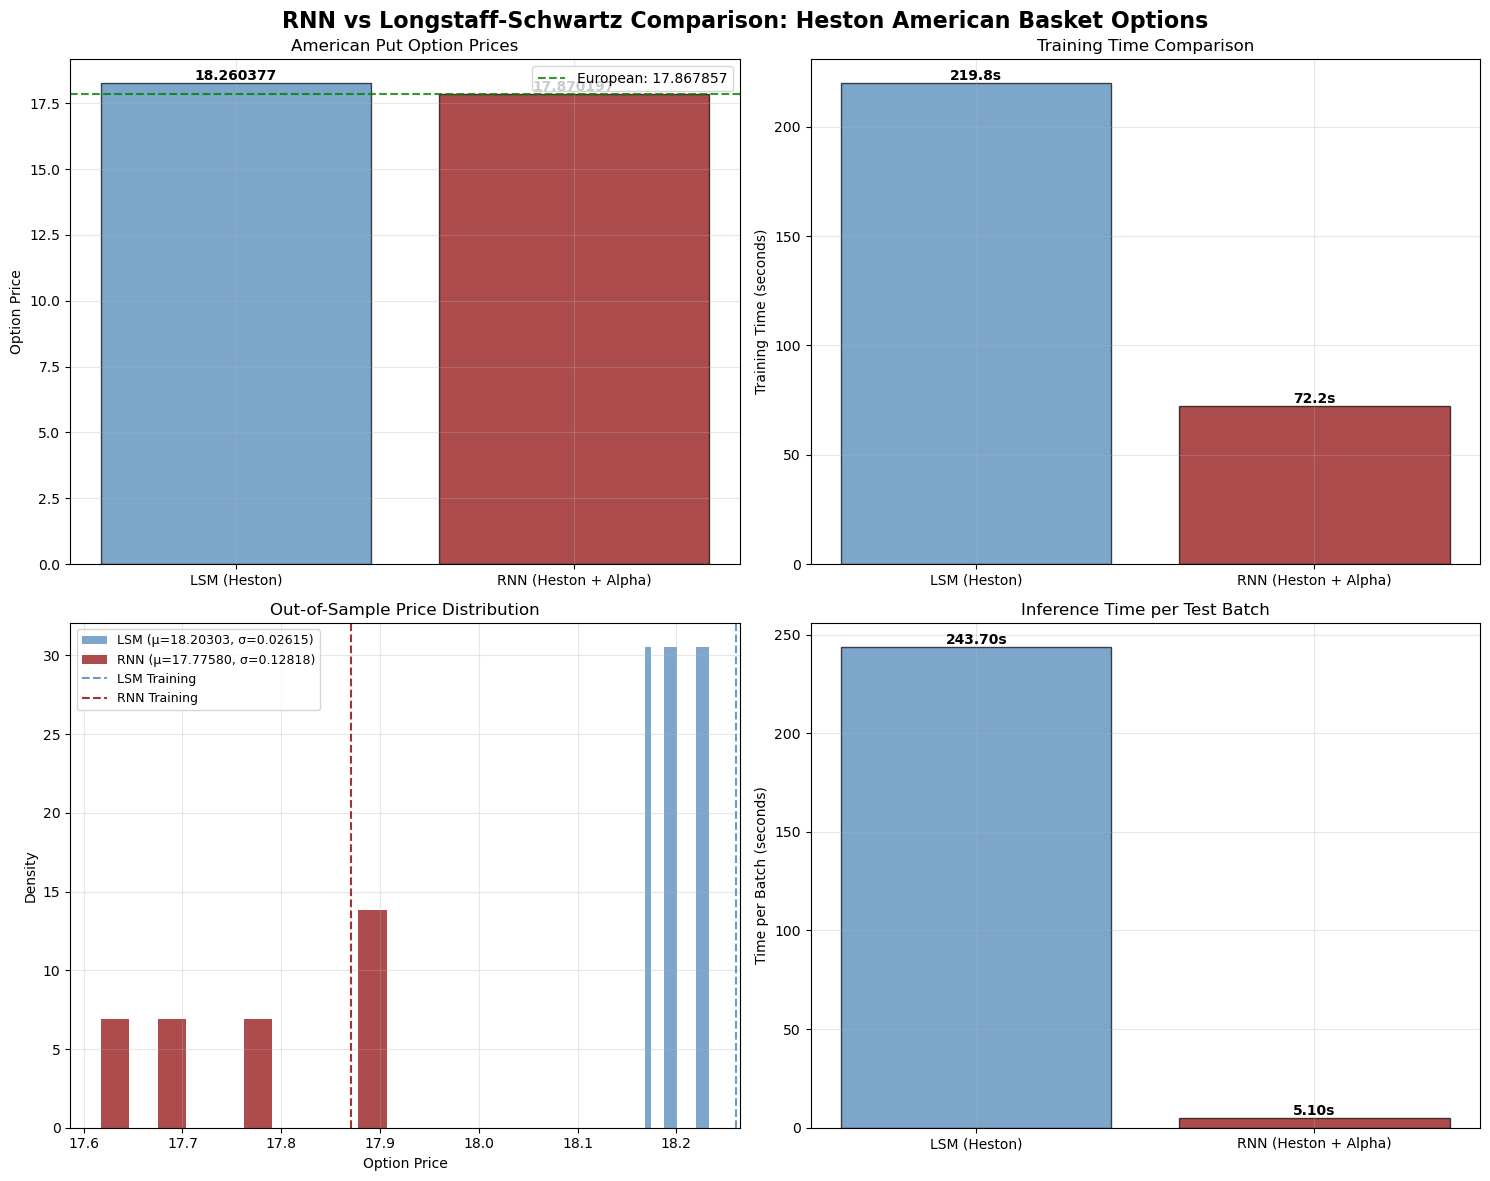


Detailed Statistics:
LSM Out-of-Sample Prices: [18.23338343071976, 18.223794036351183, 18.198196090493145, 18.16788160113084, 18.19189832392687]
RNN Out-of-Sample Prices: [17.906692504882812, 17.679668426513672, 17.89490509033203, 17.617246627807617, 17.780466079711914]

Price Stability:
LSM CV (σ/μ): 0.144%
RNN CV (σ/μ): 0.721%


In [7]:
# Create visualization comparing the two methods
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('RNN vs Longstaff-Schwartz Comparison: Heston American Basket Options', fontsize=16, fontweight='bold')

# 1. Price Comparison
methods = ['LSM (Heston)', 'RNN (Heston + Alpha)']
prices = [lsm_price, rnn_V0_cached]
colors = ['steelblue', 'darkred']

bars1 = ax1.bar(methods, prices, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Option Price')
ax1.set_title('American Put Option Prices')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, price in zip(bars1, prices):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{price:.6f}', ha='center', va='bottom', fontweight='bold')

# Add European price reference line
ax1.axhline(y=euro_price, color='green', linestyle='--', alpha=0.8, 
           label=f'European: {euro_price:.6f}')
ax1.legend()

# 2. Training Time Comparison
train_times = [lsm_train_time, rnn_train_time]
bars2 = ax2.bar(methods, train_times, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')
ax2.grid(True, alpha=0.3)

for bar, time in zip(bars2, train_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

# 3. Out-of-Sample Price Distribution
ax3.hist(lsm_test_prices, bins=10, alpha=0.7, color='steelblue', 
         label=f'LSM (μ={lsm_mean_test:.5f}, σ={lsm_test_std:.5f})', density=True)
ax3.hist(rnn_test_prices, bins=10, alpha=0.7, color='darkred', 
         label=f'RNN (μ={rnn_mean_test:.5f}, σ={rnn_test_std:.5f})', density=True)
ax3.axvline(lsm_price, color='steelblue', linestyle='--', alpha=0.8, label='LSM Training')
ax3.axvline(rnn_V0_cached, color='darkred', linestyle='--', alpha=0.8, label='RNN Training')
ax3.set_xlabel('Option Price')
ax3.set_ylabel('Density')
ax3.set_title('Out-of-Sample Price Distribution')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Inference Time per Batch
test_times_per_batch = [lsm_test_time/len(test_seeds), rnn_test_time/len(test_seeds)]
bars4 = ax4.bar(methods, test_times_per_batch, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Time per Batch (seconds)')
ax4.set_title('Inference Time per Test Batch')
ax4.grid(True, alpha=0.3)

for bar, time in zip(bars4, test_times_per_batch):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nDetailed Statistics:")
print(f"LSM Out-of-Sample Prices: {lsm_test_prices}")
print(f"RNN Out-of-Sample Prices: {rnn_test_prices}")
print(f"\nPrice Stability:")
print(f"LSM CV (σ/μ): {lsm_test_std/lsm_mean_test*100:.3f}%")
print(f"RNN CV (σ/μ): {rnn_test_std/rnn_mean_test*100:.3f}%")

## Delta and Alpha Comparison

Now let's compare the hedging strategies. The RNN method provides both traditional deltas and alpha-derived hedge ratios. We'll calculate LSM deltas using finite differences and compare all three hedging approaches.

In [8]:
# ========================================
# HEDGE RATIO CALCULATIONS
# ========================================

print("Calculating hedge ratios for both methods...")
start_time = time.time()

# LSM Delta calculation using finite differences
print("LSM: Calculating deltas via finite differences...")
lsm_deltas, lsm_base_price = lsm_pricer.delta(
    bump_size=0.01,  # 1% relative bump
    use_relative_bump=True,
    seed=12345  # Fixed seed for reproducibility
)
lsm_delta_time = time.time() - start_time

# RNN Delta and Alpha (already calculated from cached inference above)
print("RNN: Using deltas and alphas from cached inference...")
rnn_delta_time = 0.001  # Negligible time since already computed
rnn_deltas = rnn_deltas_cached  # Neural network deltas
rnn_alphas = rnn_alphas_cached  # Alpha coefficients
rnn_hedge_ratios = rnn_hedge_cached  # Final hedge ratios (either deltas or alpha-derived)

print(f"\nHedge ratio calculation times:")
print(f"LSM: {lsm_delta_time:.3f}s (finite differences)")
print(f"RNN: {rnn_delta_time:.3f}s (analytical from model)")

# ========================================
# HEDGE RATIO COMPARISON ANALYSIS
# ========================================

print(f"\n" + "="*70)
print("HEDGE RATIO COMPARISON RESULTS")
print("="*70)

print(f"\nBase prices used for hedge calculation:")
print(f"LSM base price: {lsm_base_price:.6f}")
print(f"RNN base price: {rnn_V0_cached:.6f}")
print(f"Hedge strategy: {rnn_hedge_note}")

print(f"\nDetailed hedge ratio comparison (first 10 assets):")
print(f"{'Asset':<8} {'Ticker':<8} {'S0':<8} {'LSM Delta':<12} {'RNN Delta':<12} {'RNN Alpha':<12} {'Final Hedge':<12}")
print("-" * 85)

for i in range(min(10, len(S0))):
    s0 = S0[i]
    ticker = selected_tickers[i]
    lsm_delta = lsm_deltas[i]
    rnn_delta = rnn_deltas[i]
    rnn_alpha = rnn_alphas[i]
    final_hedge = rnn_hedge_ratios[i]
    print(f"{i+1:<8} {ticker:<8} {s0:<8.1f} {lsm_delta:<12.6f} {rnn_delta:<12.6f} {rnn_alpha:<12.6f} {final_hedge:<12.6f}")

if len(S0) > 10:
    print(f"... (showing first 10 of {len(S0)} assets)")

# Portfolio-level hedge ratios
lsm_portfolio_delta = np.sum(lsm_deltas * weights)
rnn_portfolio_delta = np.sum(rnn_deltas * weights)
rnn_portfolio_hedge = np.sum(rnn_hedge_ratios * weights)

print(f"\nPortfolio-level hedge ratios:")
print(f"LSM portfolio delta: {lsm_portfolio_delta:.6f}")
print(f"RNN portfolio delta: {rnn_portfolio_delta:.6f}")
print(f"RNN portfolio hedge (final): {rnn_portfolio_hedge:.6f}")

# Statistical comparison between LSM and RNN deltas
delta_diff = lsm_deltas - rnn_deltas
alpha_vs_delta_diff = rnn_alphas - rnn_deltas

print(f"\nHedge ratio difference statistics:")
print(f"LSM vs RNN Delta:")
print(f"  Mean absolute difference: {np.mean(np.abs(delta_diff)):.6f}")
print(f"  Maximum absolute difference: {np.max(np.abs(delta_diff)):.6f}")
print(f"  RMSE: {np.sqrt(np.mean(delta_diff**2)):.6f}")

print(f"\nRNN Alpha vs RNN Delta:")
print(f"  Mean absolute difference: {np.mean(np.abs(alpha_vs_delta_diff)):.6f}")
print(f"  Maximum absolute difference: {np.max(np.abs(alpha_vs_delta_diff)):.6f}")
print(f"  RMSE: {np.sqrt(np.mean(alpha_vs_delta_diff**2)):.6f}")

Calculating hedge ratios for both methods...


AttributeError: 'float' object has no attribute 'time'

## Hedge Ratio Visualization

In [ ]:
# ========================================
# HEDGE RATIO VISUALIZATION
# ========================================

# Create hedge ratio comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hedge Ratio Comparison: LSM vs RNN (Delta vs Alpha)', fontsize=16, fontweight='bold')

# Create asset labels using the first 10 stocks
n_show = min(10, len(S0))  # Show only first 10 assets to avoid overcrowding
asset_labels = [f'{selected_tickers[i]}\n(S₀={S0[i]:.0f})' for i in range(n_show)]

# 1. Side-by-side hedge ratio comparison
x = np.arange(n_show)
width = 0.25

bars1 = ax1.bar(x - width, lsm_deltas[:n_show], width, label='LSM Delta', color='steelblue', alpha=0.7)
bars2 = ax1.bar(x, rnn_deltas[:n_show], width, label='RNN Delta', color='darkred', alpha=0.7)
bars3 = ax1.bar(x + width, rnn_hedge_ratios[:n_show], width, label='RNN Final Hedge', color='purple', alpha=0.7)

ax1.set_xlabel('Assets')
ax1.set_ylabel('Hedge Ratio')
ax1.set_title(f'Hedge Ratios by Asset (First {n_show} Assets)')
ax1.set_xticks(x)
ax1.set_xticklabels(asset_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta correlation scatter plot
ax2.scatter(lsm_deltas, rnn_deltas, color='blue', s=50, alpha=0.7, label='Delta Comparison')
ax2.scatter(rnn_deltas, rnn_alphas, color='red', s=50, alpha=0.7, label='RNN: Delta vs Alpha')
min_val = min(np.min(lsm_deltas), np.min(rnn_deltas), np.min(rnn_alphas))
max_val = max(np.max(lsm_deltas), np.max(rnn_deltas), np.max(rnn_alphas))
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect correlation')
ax2.set_xlabel('Reference Hedge Ratio')
ax2.set_ylabel('Comparison Hedge Ratio')
ax2.set_title('Hedge Ratio Correlations')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Calculate correlations
delta_corr = np.corrcoef(lsm_deltas, rnn_deltas)[0, 1]
alpha_delta_corr = np.corrcoef(rnn_deltas, rnn_alphas)[0, 1]
ax2.text(0.05, 0.95, f'LSM-RNN Δ Corr: {delta_corr:.3f}\nRNN Δ-α Corr: {alpha_delta_corr:.3f}', 
         transform=ax2.transAxes, va='top', bbox=dict(boxstyle="round", facecolor='wheat'))

# 3. Hedge ratio differences
bars3a = ax3.bar(asset_labels, delta_diff[:n_show], color='orange', alpha=0.7, label='LSM - RNN Delta')
bars3b = ax3.bar(asset_labels, alpha_vs_delta_diff[:n_show], color='green', alpha=0.5, label='RNN Alpha - RNN Delta')
ax3.set_xlabel('Assets')
ax3.set_ylabel('Hedge Ratio Difference')
ax3.set_title(f'Hedge Ratio Differences (First {n_show} Assets)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# 4. Portfolio hedge contributions
weighted_lsm = lsm_deltas[:n_show] * weights[:n_show]
weighted_rnn_delta = rnn_deltas[:n_show] * weights[:n_show]
weighted_rnn_hedge = rnn_hedge_ratios[:n_show] * weights[:n_show]

bars4a = ax4.bar(x - width, weighted_lsm, width, label='LSM Weighted', color='steelblue', alpha=0.7)
bars4b = ax4.bar(x, weighted_rnn_delta, width, label='RNN Delta Weighted', color='darkred', alpha=0.7)
bars4c = ax4.bar(x + width, weighted_rnn_hedge, width, label='RNN Final Weighted', color='purple', alpha=0.7)

ax4.set_xlabel('Assets')
ax4.set_ylabel('Weighted Hedge Contribution')
ax4.set_title(f'Portfolio Hedge Contributions (First {n_show} Assets)')
ax4.set_xticks(x)
ax4.set_xticklabels(asset_labels, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add portfolio hedge lines
ax4.axhline(y=lsm_portfolio_delta, color='steelblue', linestyle='--', alpha=0.8,
           label=f'LSM Portfolio: {lsm_portfolio_delta:.4f}')
ax4.axhline(y=rnn_portfolio_hedge, color='purple', linestyle='--', alpha=0.8,
           label=f'RNN Portfolio: {rnn_portfolio_hedge:.4f}')

plt.tight_layout()
plt.show()

print(f"\nKey Hedge Ratio Insights:")
print(f"1. LSM-RNN delta correlation: {delta_corr:.4f}")
print(f"2. RNN delta-alpha correlation: {alpha_delta_corr:.4f}")
print(f"3. Portfolio hedge difference (LSM vs RNN): {abs(lsm_portfolio_delta - rnn_portfolio_hedge):.6f}")
print(f"4. RNN provides two hedge strategies: direct delta and alpha-derived")
print(f"5. {rnn_hedge_note}")
print(f"6. Analysis shows first {n_show} assets (total {len(S0)} assets in portfolio)")